In [1]:
pip install git+https://github.com/pswpswpsw/nif.git

Note: you may need to restart the kernel to use updated packages.Collecting git+https://github.com/pswpswpsw/nif.git
  Cloning https://github.com/pswpswpsw/nif.git to c:\users\dv group\appdata\local\temp\pip-req-build-c8c6http
  Resolved https://github.com/pswpswpsw/nif.git to commit 732771baf24773e54a4b177dbaf0a1523337d6d0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'



  Running command git clone --filter=blob:none --quiet https://github.com/pswpswpsw/nif.git 'C:\Users\DV Group\AppData\Local\Temp\pip-req-build-c8c6http'


In [2]:
pip install tensorflow==2.11

In [3]:
import tensorflow as tf
import nif
import numpy as np
import time
import logging
import contextlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

In [4]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./tb-logs", update_freq='epoch')
#%load_ext tensorboard
#%tensorboard --logdir tb-logs

In [5]:
import numpy as np


class PointWiseData(object):
    """Represents point-wise data.

    Attributes:
        data_raw (numpy.ndarray): Raw data.
        data (numpy.ndarray): Normalized data.
        sample_weight (numpy.ndarray): Sample weights.
        n_p (int): Number of parameter features.
        n_x (int): Number of state features.
        n_o (int): Number of output features.
    """

    def __init__(self, parameter_data, x_data, u_data, sample_weight=None):
        """Initializes a new instance of the PointWiseData class.

        Args:
            parameter_data (numpy.ndarray): Parameter data.
            x_data (numpy.ndarray): State data.
            u_data (numpy.ndarray): Output data.
            sample_weight (numpy.ndarray): Sample weights. Defaults to None.
        """
        if sample_weight is not None:
            self.data_raw = np.hstack([parameter_data, x_data, u_data, sample_weight])
        else:
            self.data_raw = np.hstack([parameter_data, x_data, u_data])
        self.data = None
        self.sample_weight = None
        self.n_p = parameter_data.shape[-1]
        self.n_x = x_data.shape[-1]
        self.n_o = u_data.shape[-1]

    @property
    def parameter(self):
        """Returns the parameter data."""
        return self.data[:, : self.n_p]

    @property
    def x(self):
        """Returns the state data."""
        return self.data[:, self.n_p : self.n_p + self.n_x]

    @property
    def u(self):
        """Returns the output data."""
        return self.data[:, self.n_p + self.n_x : self.n_p + self.n_x + self.n_o]

    @staticmethod
    def standard_normalize(raw_data, area_weighted=False):
        """Performs standard normalization on raw data.

        Args:
            raw_data (numpy.ndarray): Raw data.
            area_weighted (bool): Whether to perform area weighting. Defaults to False.

        Returns:
            numpy.ndarray: Normalized data.
            numpy.ndarray: Mean of raw data.
            numpy.ndarray: Standard deviation of raw data.
            numpy.ndarray: Normalized sample weights.
        """
        mean = raw_data.mean(axis=0)
        std = raw_data.std(axis=0)
        if area_weighted:
            mean[-1] = 0.0
            std[-1] = np.mean(raw_data[:, -1])
            normalized_data = (raw_data - mean) / std
            return (
                normalized_data[:, :-1],
                mean,
                std,
                normalized_data[:, -1],
            )
        else:
            normalized_data = (raw_data - mean) / std
            return normalized_data, mean, std

    @staticmethod
    def minmax_normalize(raw_data, n_para, n_x, n_target, area_weighted=False):
        """Performs min-max normalization on raw data.

        Args:
            raw_data (numpy.ndarray): Raw data.
            n_para (int): Number of parameter features.
            n_x (int): Number of state features.
            n_target (int): Number of output features.
            area_weighted (bool): Whether to perform area weighting. Defaults to False.

        Returns:
            numpy.ndarray: Normalized data.
            numpy.ndarray: Mean of raw data.
            numpy.ndarray: Standard deviation of raw data.
        """
        mean = raw_data.mean(axis=0)
        std = raw_data.std(axis=0)
        for i in range(n_para + n_x):
            mean[i] = 0.5 * (np.min(raw_data[:, i]) + np.max(raw_data[:, i]))
            std[i] = 0.5 * (-np.min(raw_data[:, i]) + np.max(raw_data[:, i]))

        # also we normalize the output target to make sure the maximal is most 1
        for j in range(n_para + n_x, n_para + n_x + n_target):
            std[j] = np.max(np.abs(raw_data[:, j]))

        if area_weighted:
            # for area, simply take the mean as std for normalize
            mean[-1] = 0.0
            std[-1] = np.mean(raw_data[:, -1])
            normalized_data = (raw_data - mean) / std
            return normalized_data[:, :-1], mean, std, normalized_data[:, -1]
        else:
            normalized_data = (raw_data - mean) / std
            return raw_data, mean, std


# Load data

In [6]:
import os

import numpy as np

class TravelingWaveHighFreq(PointWiseData):
    """
    A class for loading and normalizing the traveling wave high frequency dataset.

    Attributes:
        n_p (int): The number of parameters.
        n_x (int): The number of input features.
        n_o (int): The number of output targets.

    Methods:
        __init__(): Initializes the class and loads the dataset.
        standard_normalize(raw_data, area_weighted=False): Normalizes the given data
            using standard normalization.
        minmax_normalize(raw_data, n_para, n_x, n_target, area_weighted=False):
            Normalizes the given data using min-max normalization.
    """

    def __init__(self):
        """
        Initializes the class and loads the traveling wave high frequency dataset.
        Calls the super class PointWiseData to store the parameter, x, and u data as
        data_raw. Uses the minmax_normalize method to normalize the data and store
        it as data, mean, and std.
        """
       
        data = np.load(r"D:\Liang\PIDON_NIF_20241202\NIF\Data\NIF_BUR_train.npz")["data"]

        parameter_data = data[:, [0,1]]
        x_data = data[:, [2]]
        u_data = data[:, [3]]
        super(TravelingWaveHighFreq, self).__init__(parameter_data, x_data, u_data)
        self.data, self.mean, self.std = self.minmax_normalize(
            self.data_raw, n_para=self.n_p, n_x=self.n_x, n_target=1
        )



tw = TravelingWaveHighFreq()
print(tw.data[:,0])
print(tw.data.mean(axis=0))
print(tw.data.std(axis=0))
print(tw.data.max(axis=0))
print(tw.parameter.shape)
print(tw.x.shape)
print(tw.u.shape)


[0.014 0.014 0.014 ... 0.046 0.046 0.046]
[0.03       0.5        0.5        0.00154049]
[0.01131371 0.29154759 0.29154759 0.22982383]
[0.046      1.         1.         0.54364484]
(51005, 2)
(51005, 1)
(51005, 1)


# Train 'NIFMultiScale in Burgers Equation'

In [7]:
cfg_shape_net = {
    "use_resblock":False,
    "connectivity": 'full',
    "input_dim": 1,
    "output_dim": 1,
    "units": 30,
    "nlayers": 2,
    "weight_init_factor": 0.01,
    "omega_0":30.0
}
cfg_parameter_net = {
    "use_resblock":False,
    "input_dim": 2,
    "latent_dim": 1,
    "units": 30,
    "nlayers": 2,
    "activation": 'swish'
}

enable_multi_gpu = False
enable_mixed_precision = False
nepoch = 40000
lr = 1e-3
batch_size = 1024*4
checkpt_epoch = 100
display_epoch = 100
print_figure_epoch = 100

# get training data set
train_data = tw.data
num_total_data = train_data.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[:, :3],
                                                    train_data[:, -1]))
train_dataset = train_dataset.shuffle(num_total_data).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# mixed precision?
if enable_mixed_precision:
    mixed_policy = "mixed_float16"
    # we might need this for `model.fit` to automatically do loss scaling
    policy = nif.mixed_precision.Policy(mixed_policy)
    nif.mixed_precision.set_global_policy(policy)
else:
    mixed_policy = 'float32'

class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_begin_time = time.time()
        self.history_loss = []
        logging.basicConfig(filename='./log_multiscale', level=logging.INFO, format='%(message)s')

    def on_epoch_begin(self, epoch, logs=None):
        self.ts = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % display_epoch == 0:
            tnow = time.time()
            te = tnow - self.ts
            logging.info("Epoch {:6d}: avg.loss pe = {:4.3e}, {:d} points/sec, time elapsed = {:4.3f} hours".format(
                epoch, logs['loss'], int(batch_size / te), (tnow - self.train_begin_time) / 3600.0))
            self.history_loss.append(logs['loss'])
        if epoch % print_figure_epoch == 0:
            plt.figure()
            plt.semilogy(self.history_loss)
            plt.xlabel('epoch: per {} epochs'.format(print_figure_epoch))
            plt.ylabel('MSE loss')
            plt.savefig('./loss_multiscale.png')
            plt.close()

            u_pred = self.model.predict(train_data[:,:3]).reshape(5,101,101)
            u_true = train_data[:,-1].reshape(5,101,101)
            error =  u_pred-u_true
            tt = np.linspace(0,1,101)
            xx = np.linspace(0,1,101)
            
            fig,axs=plt.subplots(1,3,figsize=(16,4))
            im1=axs[0].contourf(tt, xx, u_true[1,:,:],vmin=-6,vmax=6,levels=50,cmap='jet')
            plt.colorbar(im1,ax=axs[0])

            im2=axs[1].contourf(tt, xx, u_pred[1,:,:],vmin=-6,vmax=6,levels=50,cmap='jet')
            plt.colorbar(im2,ax=axs[1])

            im3=axs[2].contourf(tt, xx, error[1,:,:],vmin=-6,vmax=6,levels=50,cmap='jet')
            plt.colorbar(im3,ax=axs[2])

            axs[0].set_xlabel('t')
            axs[0].set_ylabel('x')
            axs[0].set_title('true')
            axs[1].set_title('pred')
            axs[2].set_title('error')
            plt.savefig('vis_multiscale.png')
            plt.close()

        if epoch % checkpt_epoch == 0 or epoch == nepoch - 1:
            print('save checkpoint epoch: %d...' % epoch)
            self.model.save_weights("./saved_weights_multiscale/ckpt-{}/ckpt".format(epoch))

        if epoch == 10000:
            print('save checkpoint epoch: %d...' % epoch)
            self.model.save_weights("./saved_weights_multiscale/ckpt-{}-10000/ckpt".format(epoch))

        if epoch == 20000:
            print('save checkpoint epoch: %d...' % epoch)
            self.model.save_weights("./saved_weights_multiscale/ckpt-{}-20000/ckpt".format(epoch))

        if epoch == 30000:
            print('save checkpoint epoch: %d...' % epoch)
            self.model.save_weights("./saved_weights_multiscale/ckpt-{}-30000/ckpt".format(epoch))


lr = 1e-3
def scheduler(epoch, lr):
    if epoch < 1000:
        return lr
    elif epoch < 2000:
        return 1e-4
    elif epoch < 4000:
        return 5e-5
    else:
        return 1e-5        
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

cm = tf.distribute.MirroredStrategy().scope() if enable_multi_gpu else contextlib.nullcontext()
with cm:
    optimizer = tf.keras.optimizers.Adam(lr)
    model_ori = nif.NIFMultiScale(cfg_shape_net, cfg_parameter_net, mixed_policy)
    model = model_ori.build()
    model.compile(optimizer, loss='mse')

callbacks = [tensorboard_callback, LossAndErrorPrintingCallback(), scheduler_callback]
model.fit(train_dataset, epochs=nepoch, batch_size=batch_size,shuffle=False, verbose=0, callbacks=callbacks,use_multiprocessing=True)

1594/1594 [==============================] - 4s 2ms/step
save checkpoint epoch: 0...
1594/1594 [==============================] - 4s 3ms/step
save checkpoint epoch: 100...
1594/1594 [==============================] - 5s 3ms/step
save checkpoint epoch: 200...
1594/1594 [==============================] - 5s 3ms/step
save checkpoint epoch: 300...
1594/1594 [==============================] - 5s 3ms/step
save checkpoint epoch: 400...
1594/1594 [==============================] - 5s 3ms/step
save checkpoint epoch: 500...
1594/1594 [==============================] - 5s 3ms/step
save checkpoint epoch: 600...
1594/1594 [==============================] - 6s 4ms/step
save checkpoint epoch: 700...
1594/1594 [==============================] - 5s 3ms/step
save checkpoint epoch: 800...
1594/1594 [==============================] - 5s 3ms/step
save checkpoint epoch: 900...
1594/1594 [==============================] - 5s 3ms/step
save checkpoint epoch: 1000...
1594/1594 [==============================] -

# Test 'NIFMultiScale in Burgers Equation'

In [26]:
test_data = np.load(r"D:\Liang\NIF\Data\NIF_BUR_test_3.npz")["output3"]

train_data_raw = np.load(r"D:\Liang\NIF\Data\NIF_BUR_train.npz")["data"]
print(train_data_raw.min(axis=0))

[ 0.014       0.          0.         -0.52908189]


In [27]:
print(test_data.min(axis=0))
print(test_data.max(axis=0))

[ 0.01        0.          0.         -0.52908189]
[0.02       3.         1.         0.54364484]


638/638 [==============================] - 2s 4ms/step


Text(0.5, 1.0, 'error')

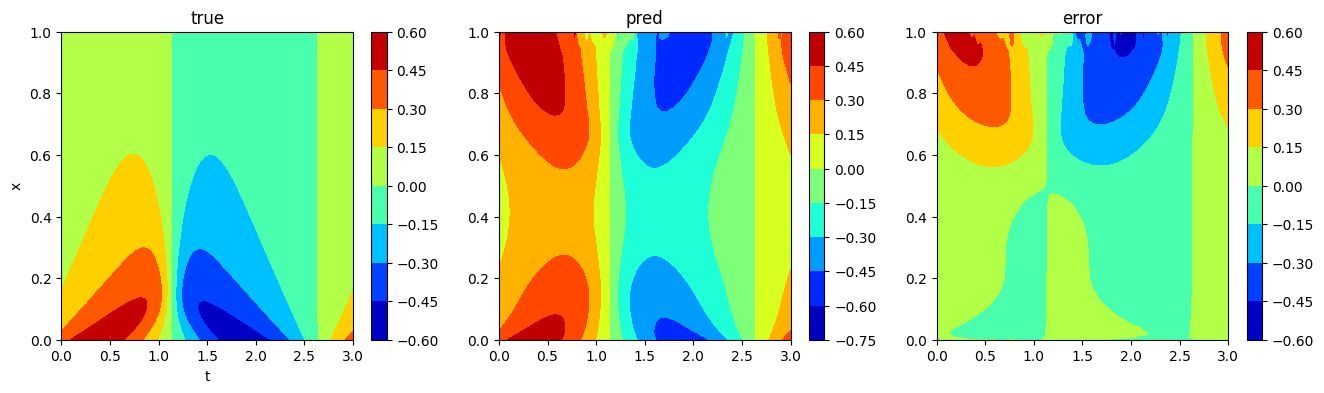

In [32]:
u_pred = model.predict(test_data[:,:3]).reshape(2,101,101)
u_true = test_data[:,-1].reshape(2,101,101)
error =  u_pred-u_true
tt = np.linspace(0,3,101)
xx = np.linspace(0,1,101)

# 1st dimension is 0: plot extrapolation prediction
# 1st dimension is 1: plot interpolation prediction
fig,axs=plt.subplots(1,3,figsize=(16,4))
im1=axs[0].contourf(tt, xx, u_true[0,:,:],cmap='jet')
plt.colorbar(im1,ax=axs[0])

im2=axs[1].contourf(tt, xx, u_pred[0,:,:],cmap='jet')
plt.colorbar(im2,ax=axs[1])

im3=axs[2].contourf(tt, xx, error[0,:,:],cmap='jet')
plt.colorbar(im3,ax=axs[2])

axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
axs[0].set_title('true')
axs[1].set_title('pred')
axs[2].set_title('error')

In [31]:
# save prediction results
from scipy.io import savemat
import numpy as np
u_pred_1 = np.transpose(u_pred, (0, 2, 1))  # exchange the last two dimensions
u_true_1 = np.transpose(u_true, (0, 2, 1))  

data = {
    'u_pred': u_pred_1,  
    'u_true': u_true_1  
}
# save data
savemat(r"D:\Liang\NIF\Data\Burger_testingResults_20241201.mat", data)
print("Data saved to Burger_testingResults_20241201.mat")

Data saved to example.mat
